# Coal Mining Disasters in the UK

Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). The number of disasters is thought to have been affected by changes in safety regulations during this period. 

Next we will build a model for this series and attempt to estimate changes in the underlying risk of disasters.

In [1]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.ma as ma
import arviz as az
import pymc as pm
cov = pm.gp.cov

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

import warnings
warnings.simplefilter('ignore')

In [4]:
# Time series of recorded coal mining disasters in the UK from 1851 to 1962
disasters_data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                        3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                        2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                        1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                        0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                        3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
year = np.arange(1851, 1962)
year_ind = (year-year.min()).reshape(-1,1)

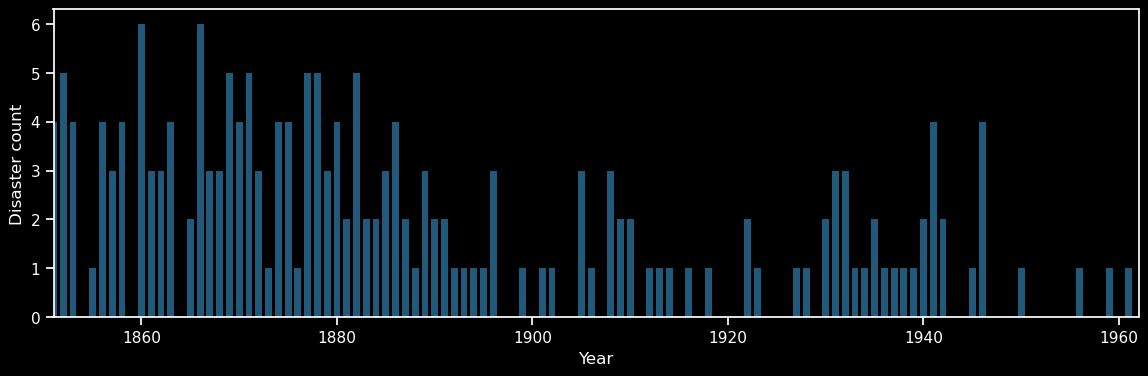

In [5]:
fig, ax = plt.subplots(figsize=(14,4))
ax.bar(year, disasters_data, color="#348ABD", alpha=0.65, width=0.7)
ax.set_xlim(year[0], year[-1]+1)
ax.set_ylabel('Disaster count')
ax.set_xlabel('Year');

In [6]:
with pm.Model() as disasters_model:
    
    ρ = pm.Exponential('ρ', 1)
    η = pm.Exponential('η', 1)
    
    K = η**2 * cov.ExpQuad(1, ρ)
    gp = pm.gp.Latent(cov_func=K)

In [7]:
with disasters_model:
    
    f = gp.prior('f', X=year_ind)

In [8]:
with disasters_model:
    
    λ = pm.Deterministic('λ', pm.math.exp(f))
    
    confirmation = pm.Poisson('confirmation', λ, observed=disasters_data)

In [9]:
with disasters_model:

    trace = pm.sample(1000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ρ, η, f_rotated_]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


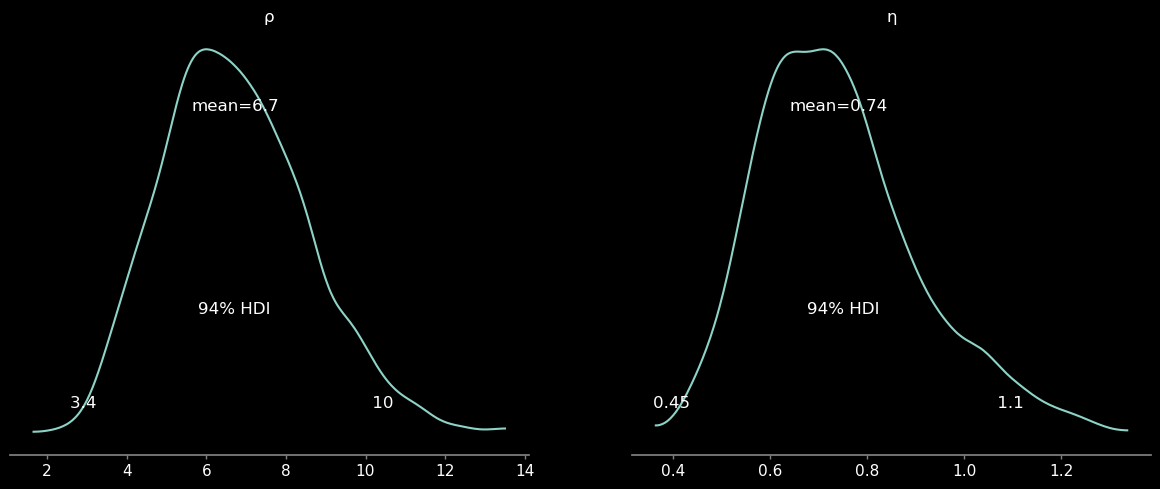

In [10]:
az.plot_posterior(trace, var_names=['ρ', 'η']);

In [11]:
years = (year - year.min())

In [12]:
with disasters_model:
    y_pred = pm.sample_posterior_predictive(trace, var_names=['f'])

Sampling: []


Output()

In [19]:
y_pred.posterior_predictive["f"][0].to_numpy()

array([[ 1.04335503,  1.07409808,  1.07599634, ..., -1.32890842,
        -1.14283479, -0.94228784],
       [ 0.89754573,  0.88286746,  0.86384883, ..., -0.76721461,
        -0.72901053, -0.70653173],
       [ 1.18895937,  1.18068843,  1.1547065 , ..., -1.0845949 ,
        -0.92517408, -0.72557896],
       ...,
       [ 0.83861985,  0.84168954,  0.83894158, ..., -0.36933689,
        -0.29014069, -0.22185736],
       [ 1.03898822,  1.05086929,  1.06066167, ..., -1.18555129,
        -1.12207179, -1.04965171],
       [ 1.27236444,  1.23174235,  1.15095592, ...,  0.079102  ,
         0.12713847,  0.17803394]])

In [22]:
help(sns.regplot)

Help on function regplot in module seaborn.regression:

regplot(data=None, *, x=None, y=None, x_estimator=None, x_bins=None, x_ci='ci', scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, label=None, color=None, marker='o', scatter_kws=None, line_kws=None, ax=None)
    Plot data and a linear regression model fit.
    
    There are a number of mutually exclusive options for estimating the
    regression model. See the :ref:`tutorial <regression_tutorial>` for more
    information.    
    
    Parameters
    ----------
    x, y: string, series, or vector array
        Input variables. If strings, these should correspond with column names
        in ``data``. When pandas objects are used, axes will be labeled with
        the series name.
    data : DataFrame
        Tidy ("long-form") dataframe where each column is

In [25]:
disasters_data

array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3,
       1, 4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1,
       1, 3, 0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1,
       1, 2, 4, 2, 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1])

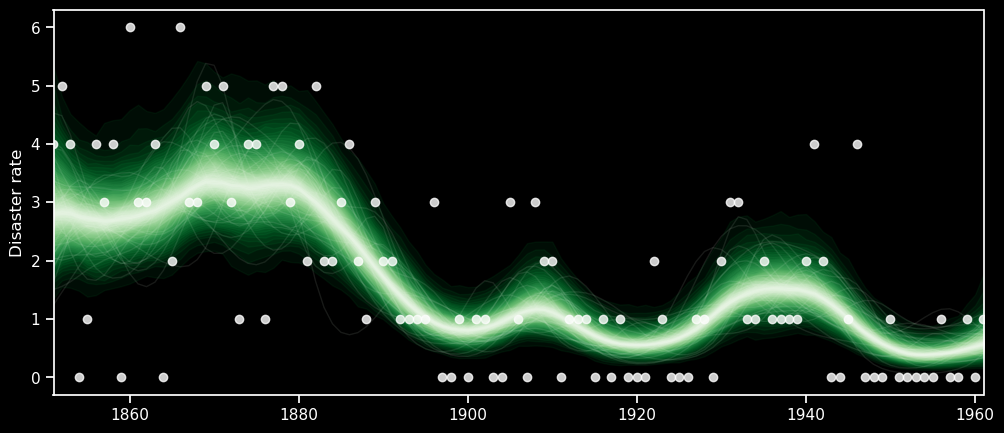

In [28]:
fig, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, np.exp(y_pred.posterior_predictive["f"][0].to_numpy()), year[:, None], palette='Greens_r', fill_alpha=0.2)
sns.regplot(x=year, y=disasters_data, fit_reg=False, ax=ax, color='w')
ax.set_xlim(year.min(), year.max())
ax.set_ylabel('Disaster rate');